<a href="https://colab.research.google.com/github/Clairekmkim/Clairekmkim/blob/main/MNIST_Digit_Generation_using_Deep_Convolutional_GAN_(DC_GAN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

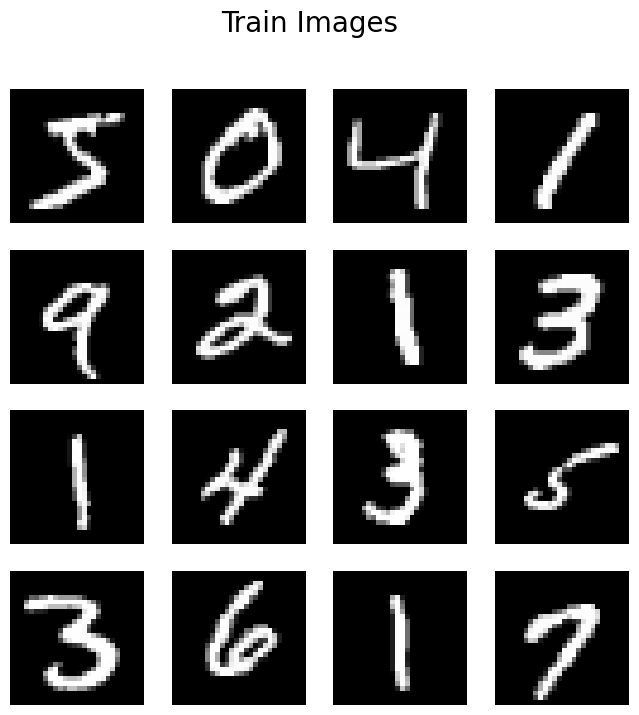

Time for epoch 1 is 47.00680422782898 sec
Time for epoch 2 is 44.706319093704224 sec
Time for epoch 3 is 45.4560706615448 sec
Time for epoch 4 is 46.22390270233154 sec
Time for epoch 5 is 81.90356802940369 sec


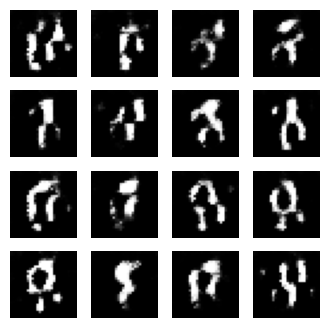

In [12]:
# Basic libraries for deep learning with TensorFlow
import tensorflow as tf                           # Main TensorFlow library
from tensorflow.keras.datasets import mnist       # For loading MNIST dataset
from tensorflow.keras import layers               # Neural network layers

# Data manipulation and visualization
import matplotlib.pyplot as plt                   # For plotting
import pandas as pd                              # For data manipulation
import numpy as np                               # For numerical operations
import time                                      # For timing operations

# 주요 라이브러리의 역할:
# 1. tensorflow(tf): 딥러닝 모델 구현의 핵심 라이브러리
# 2. keras: tensorflow의 high-level API로, 쉬운 모델 구현 가능
# 3. matplotlib: 데이터와 결과를 시각화
# 4. pandas: 데이터 처리와 분석
# 5. numpy: 수치 계산
# 6. time: 학습 시간 측정 등 시간 관련 기능

# Load MNIST dataset which is split into training and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# x_train: 60,000 training images (28x28 pixels)
# y_train: 60,000 training labels (0-9 digits)
# x_test: 10,000 test images (28x28 pixels)
# y_test: 10,000 test labels (0-9 digits)

# 8x8 크기의 그래프 창 생성
plt.figure(figsize=(8, 8))

# 16개의 학습 이미지를 4x4 그리드로 표시
for i in range(16):
   # 4x4 그리드의 i+1번째 위치에 서브플롯 생성
   plt.subplot(4, 4, i+1)

   # 전체 그래프의 제목 설정
   plt.suptitle('Train Images', fontsize=20)

   # 이미지를 흑백(grayscale)으로 표시
   plt.imshow(x_train[i], cmap=plt.cm.gray)

   # 축 눈금 제거
   plt.axis("off")

# 그래프 표시
plt.show()

# 이미지를 32비트 float 타입으로 변환하고 reshape
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')

# 픽셀값을 -1에서 1 사이로 정규화 (-1 ~ 1)
x_train = (x_train - 127.5) / 127.5

# 데이터셋 파라미터 설정
BUFFER_SIZE = 60000  # 전체 학습 데이터 크기
BATCH_SIZE = 256    # 한 번에 처리할 데이터 수
noise_dim = 100     # 노이즈 벡터의 크기

# 데이터셋 준비
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

def make_generator_model():
   # 생성자 모델 초기화
   model = tf.keras.Sequential()

   # 첫 번째 레이어: 밀집층
   model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
   model.add(layers.BatchNormalization())
   model.add(layers.LeakyReLU())

   # 7x7x256 크기로 reshape
   model.add(layers.Reshape((7, 7, 256)))

   # 첫 번째 전치 합성곱 층
   model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
   model.add(layers.BatchNormalization())
   model.add(layers.LeakyReLU())

   # 두 번째 전치 합성곱 층
   model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
   model.add(layers.BatchNormalization())
   model.add(layers.LeakyReLU())

   # 마지막 전치 합성곱 층
   model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

   return model

# 생성자 모델 생성
generator = make_generator_model()

def make_discriminator_model():
   # 구분자 모델 초기화
   model = tf.keras.Sequential()

   # 첫 번째 합성곱 층
   model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                          input_shape=[28, 28, 1]))
   model.add(layers.LeakyReLU())
   model.add(layers.Dropout(0.3))

   # 두 번째 합성곱 층
   model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
   model.add(layers.LeakyReLU())
   model.add(layers.Dropout(0.3))

   # 평탄화 및 출력층
   model.add(layers.Flatten())
   model.add(layers.Dense(1))    # 진짜/가짜 판별을 위한 1개 출력

   return model

# 구분자 모델 생성
discriminator = make_discriminator_model()

# 이진 크로스 엔트로피 손실 함수 정의
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 구분자(Discriminator)의 손실 함수 정의
def discriminator_loss(real_output, fake_output):
   # 진짜 이미지에 대한 손실 계산 (목표: 1로 분류)
   real_loss = cross_entropy(tf.ones_like(real_output), real_output)

   # 가짜 이미지에 대한 손실 계산 (목표: 0으로 분류)
   fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

   # 전체 손실 = 진짜 손실 + 가짜 손실
   total_loss = real_loss + fake_loss

   return total_loss

   # 생성자(Generator)의 손실 함수 정의
def generator_loss(fake_output):
   # 가짜 이미지를 진짜처럼 보이게 만드는 것이 목표
   return cross_entropy(tf.ones_like(fake_output), fake_output)

   # 생성자와 구분자의 최적화 함수 정의
generator_optimizer = tf.keras.optimizers.Adam(1e-4)      # 생성자의 최적화 함수
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)  # 구분자의 최적화 함수

def train_step(images):
   # 랜덤 노이즈 생성
   noise = tf.random.normal([BATCH_SIZE, noise_dim])

   with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
       # 생성자가 가짜 이미지 생성
       generated_images = generator(noise, training=True)

       # 구분자가 진짜/가짜 이미지 판별
       real_output = discriminator(images, training=True)
       fake_output = discriminator(generated_images, training=True)

       # 각각의 손실 계산
       gen_loss = generator_loss(fake_output)
       disc_loss = discriminator_loss(real_output, fake_output)

   # 기울기(gradient) 계산
   gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
   gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

   # 최적화 수행
   generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
   discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
   # 전체 학습 과정
    for epoch in range(epochs):
       # 각 epoch 시작 시간 기록
       start = time.time()

       # 배치 단위로 학습 수행
       for image_batch in dataset:
           train_step(image_batch)

       # 각 epoch 종료 시간 기록
       end = time.time()

       # epoch 수행 시간 출력
       print('Time for epoch {} is {} sec'.format(epoch + 1, end-start))

# 전체 학습 epoch 수 설정
EPOCHS = 5

# 모델 학습 시작
train(train_dataset, EPOCHS)

# 생성할 이미지 개수 설정
num_examples_to_generate = 16

# 랜덤 시드(노이즈) 생성
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# 생성자를 사용해 가짜 이미지 생성 (학습 모드 아님)
gen_images = generator(seed, training=False)

# 4x4 크기의 그래프 창 생성
fig = plt.figure(figsize=(4,4))

# 16개의 생성된 이미지를 시각화
for i in range(gen_images.shape[0]):
   plt.subplot(4, 4, i+1)
   # 이미지 값을 0-255 범위로 복원 (정규화 반대 과정)
   plt.imshow(gen_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
   plt.axis('off')